This notebook is used to explore how to pull pretrained yolo model from hugging face load it and finetune. The dataset i will be using is located at "D:\code\unet-kedro\data\05_model_input\mix_beads" the label is mix_beads.json which needs to be converted from rle format in to a segmentation mask. We take the max and min x,y + 5 pixels as the bounding box for the target. check if the image is already at edge to prevent out of bound.


<step>1. First, let's set up the imports and load the YOLO model</step>

In [56]:
import json
import os
import numpy as np
from PIL import Image
import torch
from transformers import YolosImageProcessor, YolosForObjectDetection
import pycocotools.mask as mask_util
import cv2
from utils.parse_label_json import LabelParser
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load pretrained YOLO model
model_name = "hustvl/yolos-tiny"
processor = YolosImageProcessor.from_pretrained(model_name)
model = YolosForObjectDetection.from_pretrained(model_name)



<step>2. Load the dataset and JSON annotations</step>

In [57]:
# Set paths
data_dir = r"D:/code/unet-kedro/data/05_model_input/mix_beads"
json_path = os.path.join(data_dir, "mix_beads.json")

# Load annotations
with open(json_path, 'r') as f:
    annotations = json.load(f)

# Get list of image files
image_files = [f for f in os.listdir(data_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]


<step>3. Create functions to convert RLE to mask and generate bounding boxes</step>

In [58]:
# def rle_to_mask(rle, shape):
#     """Convert RLE to binary mask"""
#     if isinstance(rle, dict):
#         rle = rle['counts']
#     return mask_util.decode({"counts": rle, "size": shape}).astype(np.uint8)

def get_bbox_from_mask(mask, padding=5):
    """Get bounding box coordinates from mask with padding"""
    # Find non-zero points
    y_indices, x_indices = np.nonzero(mask)
    
    if len(x_indices) == 0 or len(y_indices) == 0:
        return None
    
    # Get min/max coordinates
    xmin = max(0, int(x_indices.min()) - padding)
    xmax = min(mask.shape[1], int(x_indices.max()) + padding)
    ymin = max(0, int(y_indices.min()) - padding)
    ymax = min(mask.shape[0], int(y_indices.max()) + padding)
    
    return [xmin, ymin, xmax, ymax]


<step>4. Process images and create YOLO format dataset also visualise it</step>

In [59]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_sample(image, bbox, mask, title=None):
    """
    Visualize an image with its bounding box and mask
    Args:
        image: numpy array of shape (H, W, C)
        bbox: list of [xmin, ymin, xmax, ymax]
        mask: numpy array of shape (H, W)
        title: optional title for the plot
    """
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original image
    ax1.imshow(image, cmap='gray' if image.shape[-1] == 1 else None)
    ax1.set_title('Original Image')
    
    # Plot image with bounding box
    ax2.imshow(image, cmap='gray' if image.shape[-1] == 1 else None)
    xmin, ymin, xmax, ymax = bbox
    rect = patches.Rectangle(
        (xmin, ymin), xmax-xmin, ymax-ymin,
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax2.add_patch(rect)
    ax2.set_title('Image with Bounding Box')
    
    # Plot mask
    ax3.imshow(mask, cmap='gray')
    ax3.set_title('Segmentation Mask')
    
    if title:
        fig.suptitle(title)
    
    plt.tight_layout()
    plt.show()

In [60]:
def process_dataset(data_dir, json_path):
    # Load annotations
    with open(json_path, 'r') as f:
        json_data = json.load(f)
    
    # Use LabelParser with parse_by_image_number=False for direct filename matching
    masks_dict = LabelParser.parse_json(json_data, parse_by_image_number=False)
    logger.info(f"Processing {len(masks_dict)} images from JSON")
    
    dataset = []
    first_logged = False
    
    for filename, mask in masks_dict.items():
        # Find corresponding image file
        img_path = os.path.join(data_dir, filename)
        if not os.path.exists(img_path):
            logger.warning(f"Cannot find image file at: {img_path}")
            continue
            
        # Load image
        try:
            image = Image.open(img_path)
            img_array = np.array(image)
            
            # Log shape info only for first image
            if not first_logged:
                logger.info(f"Example image shape (before conversion): {img_array.shape}")
            
            # Convert grayscale to RGB if needed
            if len(img_array.shape) == 2:
                img_array = np.stack((img_array,) * 3, axis=-1)
                if not first_logged:
                    logger.info(f"Example image shape (after RGB conversion): {img_array.shape}")
            
            # Get bounding box from mask
            bbox = get_bbox_from_mask(mask)
            if bbox is not None:
                dataset.append({
                    'image': img_array,
                    'boxes': [{
                        'bbox': bbox,
                        'category_id': 0  # Single class for beads
                    }],
                    'image_path': img_path,
                    'mask': mask  # Store mask for visualization
                })
                
                # Visualize first valid sample
                if not first_logged:
                    visualize_sample(
                        img_array, 
                        bbox, 
                        mask,
                        f"Sample Processing for {filename}"
                    )
                    first_logged = True
                    
        except Exception as e:
            logger.error(f"Failed to load/process image {filename}: {str(e)}")
            continue
    
    logger.info(f"Successfully processed {len(dataset)} images with valid bounding boxes")
    return dataset

# def process_dataset(data_dir, json_path):
#     # Load annotations
#     with open(json_path, 'r') as f:
#         json_data = json.load(f)
    
#     # Use LabelParser with parse_by_image_number=False for direct filename matching
#     masks_dict = LabelParser.parse_json(json_data, parse_by_image_number=False)
#     logger.info(f"Processing {len(masks_dict)} images from JSON")
    
#     dataset = []
#     first_logged = False
    
#     for filename, mask in masks_dict.items():
#         # Find corresponding image file
#         img_path = os.path.join(data_dir, filename)
#         if not os.path.exists(img_path):
#             logger.warning(f"Cannot find image file at: {img_path}")
#             continue
            
#         # Load image
#         try:
#             image = Image.open(img_path)
#             img_array = np.array(image)
            
#             # Log shape info only for first image
#             if not first_logged:
#                 logger.info(f"Example image shape (before conversion): {img_array.shape}")
#                 first_logged = True
            
#             # Convert grayscale to RGB if needed
#             if len(img_array.shape) == 2:
#                 img_array = np.stack((img_array,) * 3, axis=-1)
#                 if not first_logged:
#                     logger.info(f"Example image shape (after RGB conversion): {img_array.shape}")
                
#         except Exception as e:
#             logger.error(f"Failed to load/process image {filename}: {str(e)}")
#             continue
        
#         # Get bounding box from mask
#         bbox = get_bbox_from_mask(mask)
#         if bbox is not None:
#             dataset.append({
#                 'image': img_array,
#                 'boxes': [{
#                     'bbox': bbox,
#                     'category_id': 0  # Single class for beads
#                 }],
#                 'image_path': img_path
#             })
    
#     logger.info(f"Successfully processed {len(dataset)} images with valid bounding boxes")
#     return dataset




<step>5. Prepare training function</step>

In [61]:
def prepare_for_training(dataset):
    training_examples = []
    logger.info("Preparing training examples...")
    
    for idx, item in enumerate(dataset):
        # Format annotations in COCO format
        annotations = {
            'image_id': idx,
            'annotations': []
        }
        
        for box in item['boxes']:
            xmin, ymin, xmax, ymax = box['bbox']
            # Calculate area
            width_box = xmax - xmin
            height_box = ymax - ymin
            area = width_box * height_box
            
            annotations['annotations'].append({
                'bbox': box['bbox'],
                'category_id': box['category_id'],
                'area': area,
                'iscrowd': 0
            })
        
        # Prepare inputs
        encoding = processor(
            images=item['image'],
            annotations=annotations,
            return_tensors="pt"
        )
        
        training_examples.append(encoding)
        
        # Log example for first image only
        if idx == 0:
            logger.info(f"Example training data:")
            logger.info(f"- Image shape: {item['image'].shape}")
            logger.info(f"- Annotation structure: {annotations}")
            break  # Early exit after first image for testing
    
    return training_examples

# def prepare_for_training(dataset):
    training_examples = []
    
    for idx, item in enumerate(dataset):
        # Convert boxes to YOLO format (normalized coordinates)
        height, width = item['image'].shape[:2]
        
        # Format annotations in COCO format
        annotations = {
            'image_id': idx,
            'annotations': []
        }
        
        for box in item['boxes']:
            xmin, ymin, xmax, ymax = box['bbox']
            # Calculate area
            width_box = xmax - xmin
            height_box = ymax - ymin
            area = width_box * height_box
            
            annotations['annotations'].append({
                'bbox': box['bbox'],
                'category_id': box['category_id'],
                'area': area,
                'iscrowd': 0
            })
        
        # Prepare inputs
        encoding = processor(
            images=item['image'],
            annotations=annotations,
            return_tensors="pt"
        )
        
        training_examples.append(encoding)
        
        # Log first image only
        if idx == 0:
            logger.info(f"First image shape: {item['image'].shape}")
            logger.info(f"First image annotations: {annotations}")
            break  # Early exit after first image for testing
    
    return training_examples


<step>6. Main execution</step>

INFO:utils.parse_label_json:Processing 400 total instances from Label Studio JSON


INFO:utils.parse_label_json:Successfully parsed 238 masks from Label Studio JSON
INFO:__main__:Processing 238 images from JSON
INFO:__main__:Example image shape (before conversion): (300, 704)
INFO:__main__:Example image shape (after RGB conversion): (300, 704, 3)


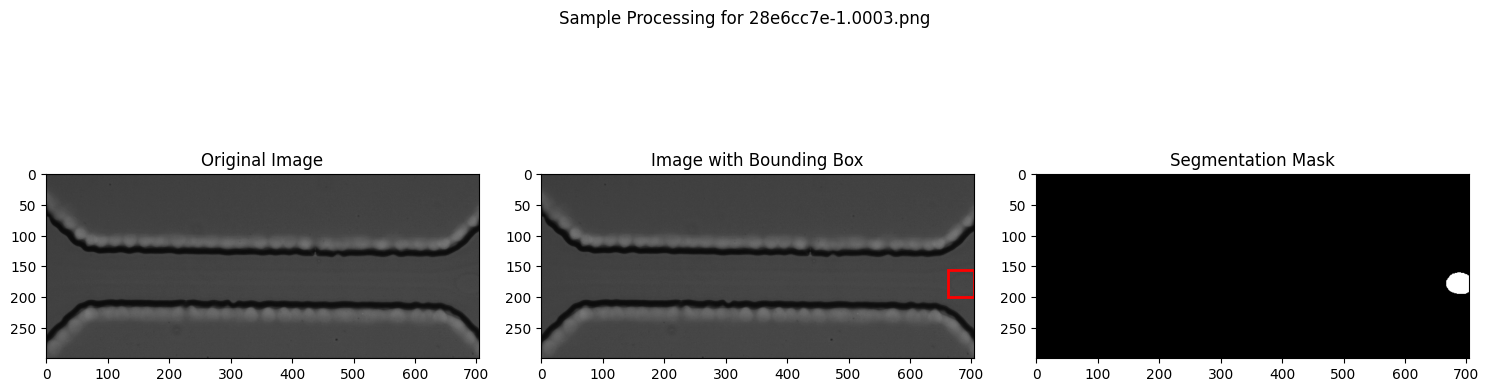

INFO:__main__:Successfully processed 238 images with valid bounding boxes
INFO:__main__:Processed 238 images
INFO:__main__:Preparing training examples...
INFO:__main__:Example training data:
INFO:__main__:- Image shape: (300, 704, 3)
INFO:__main__:- Annotation structure: {'image_id': 0, 'annotations': [{'bbox': [662, 156, 704, 200], 'category_id': 0, 'area': 1848, 'iscrowd': 0}]}
INFO:__main__:Prepared 1 training examples
INFO:__main__:First example shape: torch.Size([1, 3, 512, 1200])
INFO:__main__:First example boxes: [{'size': tensor([ 512, 1200]), 'image_id': tensor([0]), 'class_labels': tensor([0]), 'boxes': tensor([[0.9702, 0.7600, 0.0597, 0.4800]]), 'area': tensor([5376.]), 'iscrowd': tensor([0]), 'orig_size': tensor([300, 704])}]


In [62]:
def main():
    # Set paths
    data_dir = r"D:\code\unet-kedro\data\05_model_input\mix_beads"
    json_path = os.path.join(data_dir, "mix_beads.json")
    
    # Process dataset
    dataset = process_dataset(data_dir, json_path)
    logger.info(f"Processed {len(dataset)} images")
    
    # Prepare for training
    training_examples = prepare_for_training(dataset)
    logger.info(f"Prepared {len(training_examples)} training examples")
    
    # Example of accessing first item
    if training_examples:
        first_example = training_examples[0]
        logger.info(f"First example shape: {first_example['pixel_values'].shape}")
        logger.info(f"First example boxes: {first_example['labels']}")

main()